In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)
warnings.simplefilter(action='ignore')
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae
from cashew import linear_regression as lr

directory = 'expfile_influence/1/'
archives = [os.path.join(directory, f) for f in os.listdir(directory)]
archives

c0a430e3a498fc690b6244ca9909444040c28128


['expfile_influence/1/grenoble_2020-11-22_1961194.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961210.zip',
 'expfile_influence/1/grenoble_2020-11-23_1961867.zip',
 'expfile_influence/1/grenoble_2020-11-21_1960104.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961129.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961092.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961121.zip',
 'expfile_influence/1/grenoble_2020-11-21_1960106.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961104.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961052.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961118.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961045.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961051.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961101.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961117.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961110.zip',
 'expfile_influence/1/grenoble_2020-11-22_1961187.zip',
 'expfile_influence/1/grenoble_2020-11-22_196108

In [2]:
dataframes = []
for archi in archives:
    df = ae.read_performance(archi)
    df['expfile'] = ae.read_yaml(archi, 'info.yaml')['expfile'][0]
    dataframes.append(df)

df = pandas.concat(dataframes)
print(len(df))
df.head()

13496925


,function,m,n,k,timestamp,duration,core,node,cluster,jobid,cpu,start_time,index,expfile_hash,expfile
0,dgemm,775,8970,720,210.246909,0.378671,0,7,dahu,1961194,0,1606070717,0,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,exp_dgemm_c.csv
1,dgemm,1459,4731,821,210.625606,0.409976,0,7,dahu,1961194,0,1606070717,1,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,exp_dgemm_c.csv
2,dgemm,1744,978,4493,211.035591,0.566739,0,7,dahu,1961194,0,1606070717,2,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,exp_dgemm_c.csv
3,dgemm,743,1386,9703,211.602337,0.742962,0,7,dahu,1961194,0,1606070717,3,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,exp_dgemm_c.csv
4,dgemm,535,1202,5696,212.345308,0.281321,0,7,dahu,1961194,0,1606070717,4,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,exp_dgemm_c.csv


## Distribution of the sizes

In [3]:
mn = pandas.Series((df['m'] * df['n']).unique())
equi_line = []
for i, med_mn in enumerate(mn.quantile([0.25, 0.5, 0.75])):
    med_mn = int(med_mn)
    tmp = pandas.DataFrame({'m':range(1, med_mn, med_mn//1000000)})
    tmp['n'] = med_mn/tmp['m']
    tmp['group'] = i
    equi_line.append(tmp)
equi_line = pandas.concat(equi_line)
equi_line = equi_line[(equi_line['m'] <= df['m'].max()) & (equi_line['n'] <= df['n'].max())]
equi_line

,m,n,group
75,76,14947.039474,0
76,77,14752.922078,0
77,78,14563.782051,0
78,79,14379.430380,0
79,80,14199.687500,0
...,...,...,...
2998,14991,380.972317,2
2999,14996,380.845292,2
3000,15001,380.718352,2
3001,15006,380.591497,2


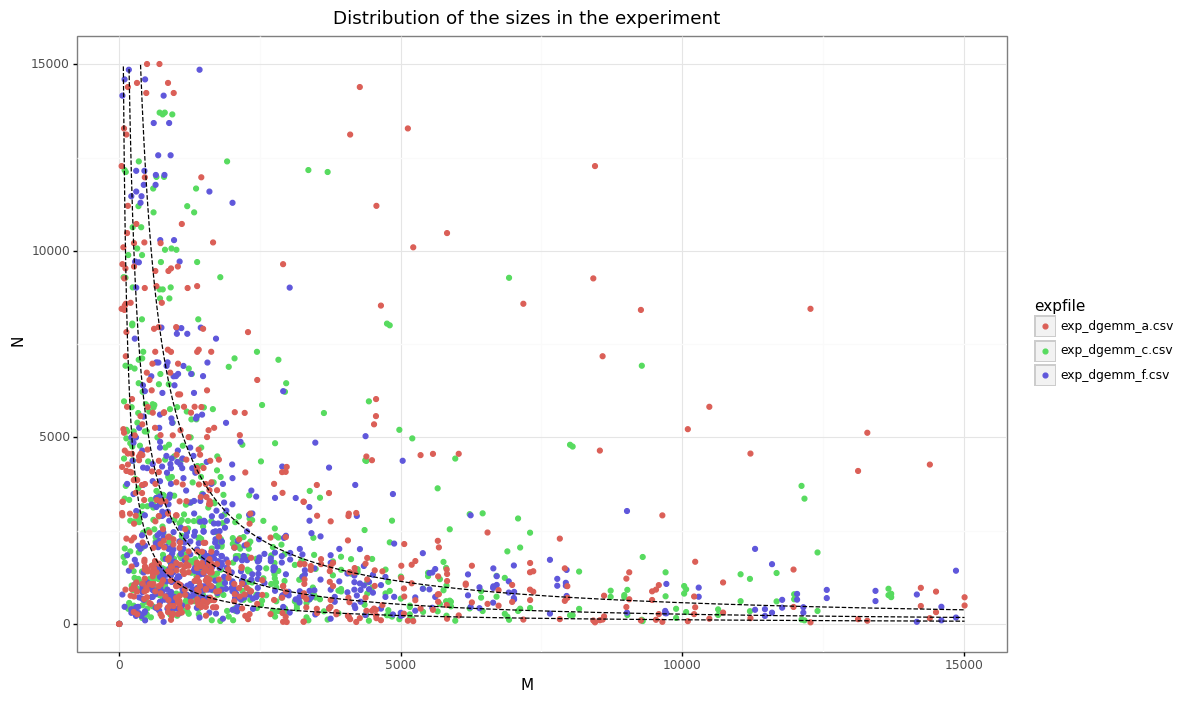

<ggplot: (8734823310428)>


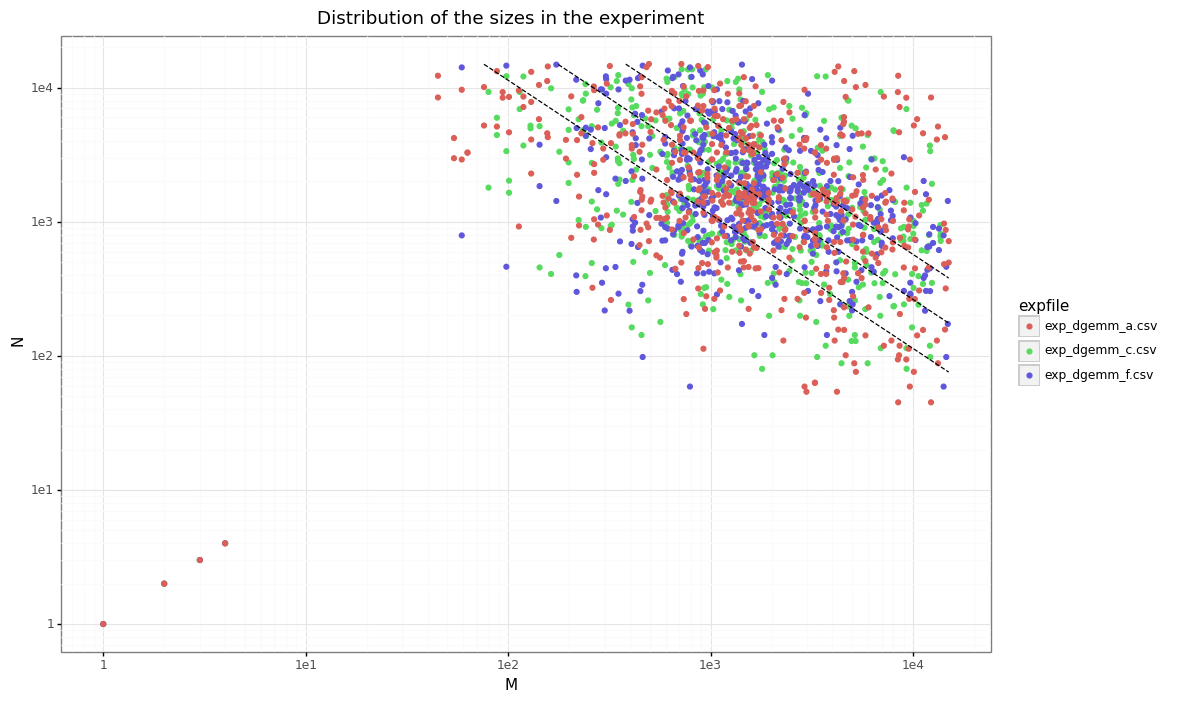

<ggplot: (-9223363302063310290)>


In [4]:
plot = (ggplot(df[['expfile', 'm', 'n', 'k']].drop_duplicates())
    + aes(x='m', y='n', color='expfile')
    + geom_point()
    + geom_line(aes(group='group'), data=equi_line, color='black', linetype='dashed')
    + theme_bw()
    + labs(x='M', y='N')
    + ggtitle('Distribution of the sizes in the experiment')
    + expand_limits(y=0)
)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

## Performance

In [5]:
aggregated_df = pandas.DataFrame(lr.regression(df, lr.compute_dgemm_reg)).set_index('jobid')
aggregated_df['expfile'] = df[['jobid', 'expfile']].drop_duplicates().set_index('jobid')
aggregated_df = aggregated_df.reset_index()
aggregated_df.head()

,jobid,intercept,mnk,mn,mk,nk,tvalue_mnk,tvalue_mn,tvalue_mk,tvalue_nk,...,tvalue_mk_residual,tvalue_nk_residual,avg_gflops,function,cluster,node,expfile_hash,cpu,start_time,expfile
0,1960064,0,7.377506e-11,1.926812e-10,2.509296e-09,3.403386e-09,566.083918,4.512188,58.762446,79.700134,...,1.183218,4.078214,24.629904,dgemm,dahu,1,dee8f2ee4599e5ef4616f67733e1b4c1934fb113f59566...,0,1605895434,exp_dgemm_a.csv
1,1960064,0,6.984817e-11,1.612105e-10,2.444577e-09,3.237123e-09,521.197121,3.671275,55.670787,73.719579,...,1.393507,9.406383,25.993361,dgemm,dahu,1,dee8f2ee4599e5ef4616f67733e1b4c1934fb113f59566...,1,1605895434,exp_dgemm_a.csv
2,1960064,0,7.192536e-11,2.278797e-10,2.516272e-09,3.631048e-09,579.805074,5.606376,61.906215,89.332329,...,2.886195,8.255645,25.099365,dgemm,dahu,2,dee8f2ee4599e5ef4616f67733e1b4c1934fb113f59566...,0,1605895434,exp_dgemm_a.csv
3,1960064,0,6.848192e-11,1.804712e-10,2.424035e-09,3.507951e-09,583.681448,4.694448,63.054424,91.249430,...,3.051112,9.116382,26.341926,dgemm,dahu,2,dee8f2ee4599e5ef4616f67733e1b4c1934fb113f59566...,1,1605895434,exp_dgemm_a.csv
4,1960064,0,7.166739e-11,1.853095e-10,2.489088e-09,3.456632e-09,544.637293,4.297937,57.730143,80.170677,...,1.802876,6.813424,25.275067,dgemm,dahu,3,dee8f2ee4599e5ef4616f67733e1b4c1934fb113f59566...,0,1605895434,exp_dgemm_a.csv


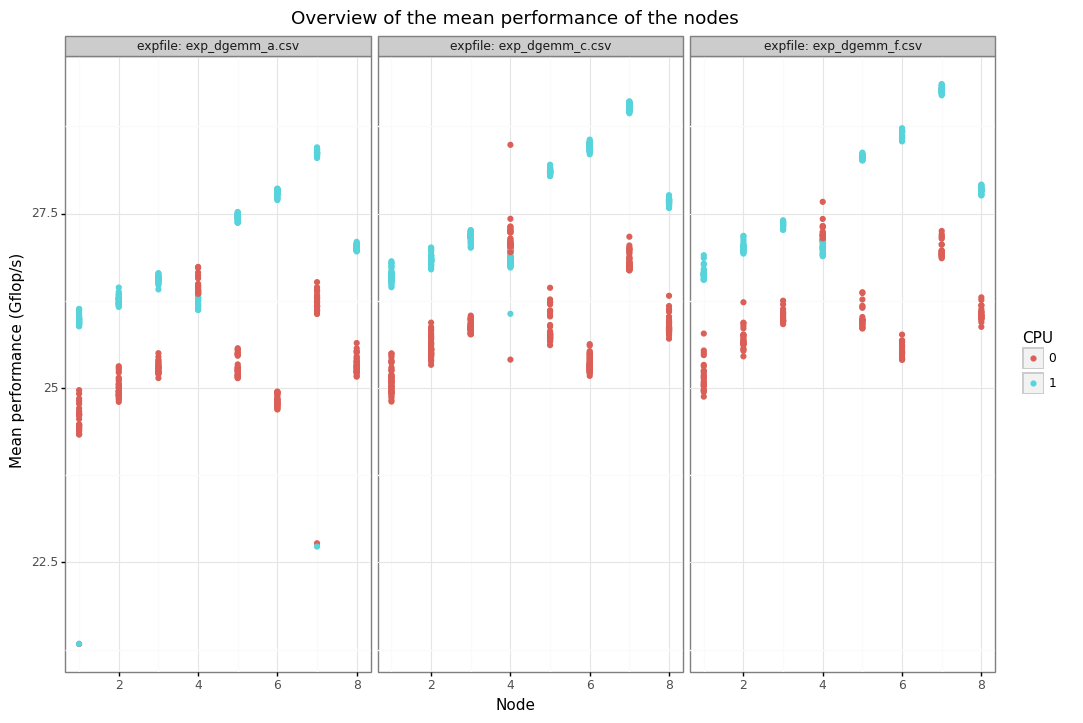

<ggplot: (-9223363302026474748)>

In [6]:
(ggplot(aggregated_df)
    + aes(x='node', y='avg_gflops', color='factor(cpu)')
    + geom_point()
    + theme_bw()
    + facet_wrap('expfile', labeller='label_both')
    + labs(x='Node', y='Mean performance (Gflop/s)', color='CPU')
    + ggtitle('Overview of the mean performance of the nodes')
   # + expand_limits(y=0)
)

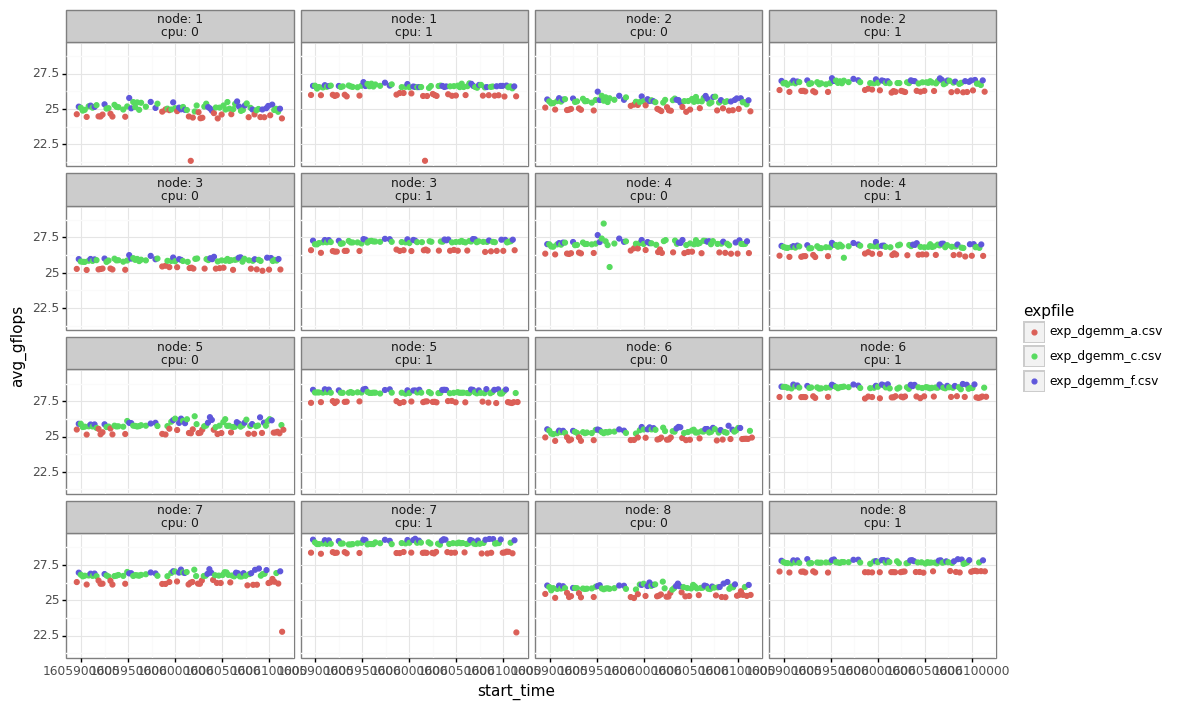

<ggplot: (8734827187299)>


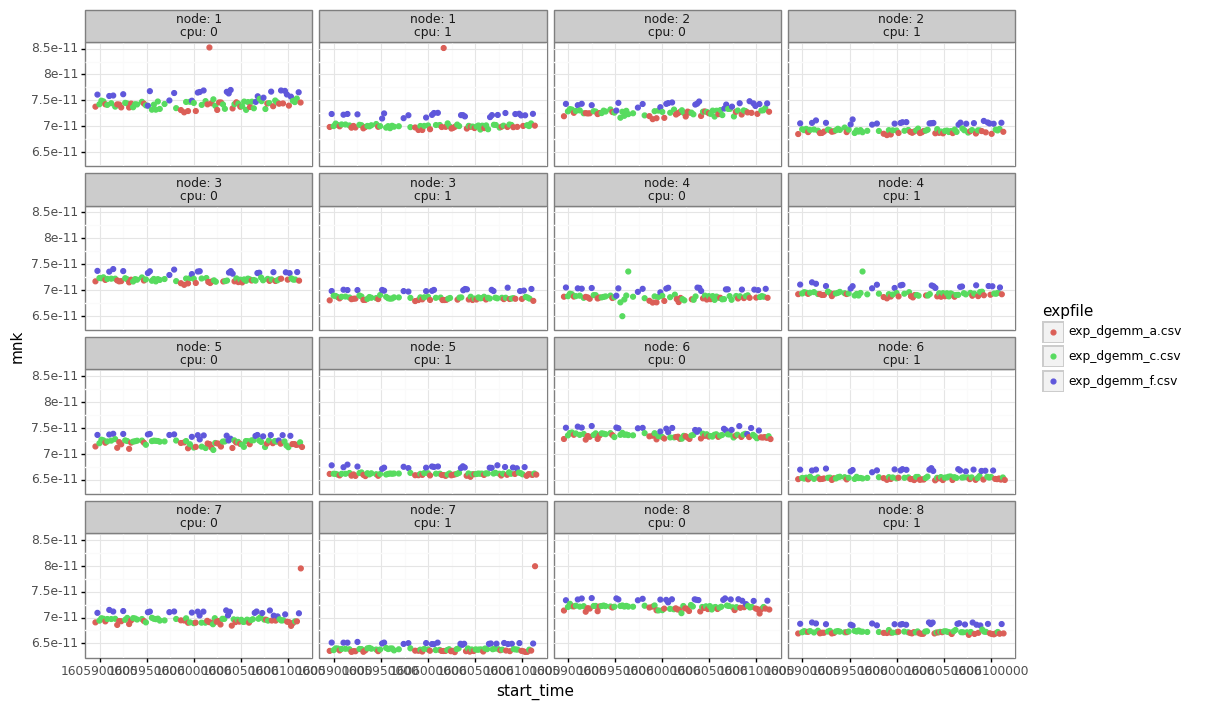

<ggplot: (-9223363302063625647)>


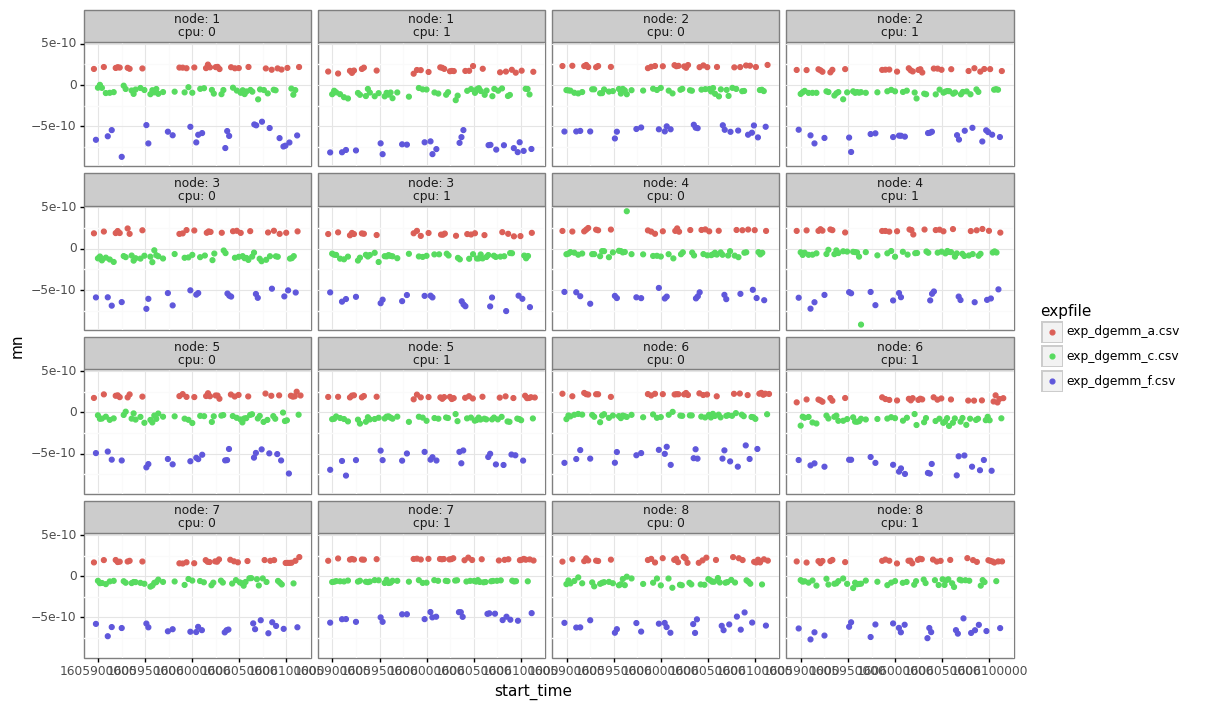

<ggplot: (-9223363302063735089)>


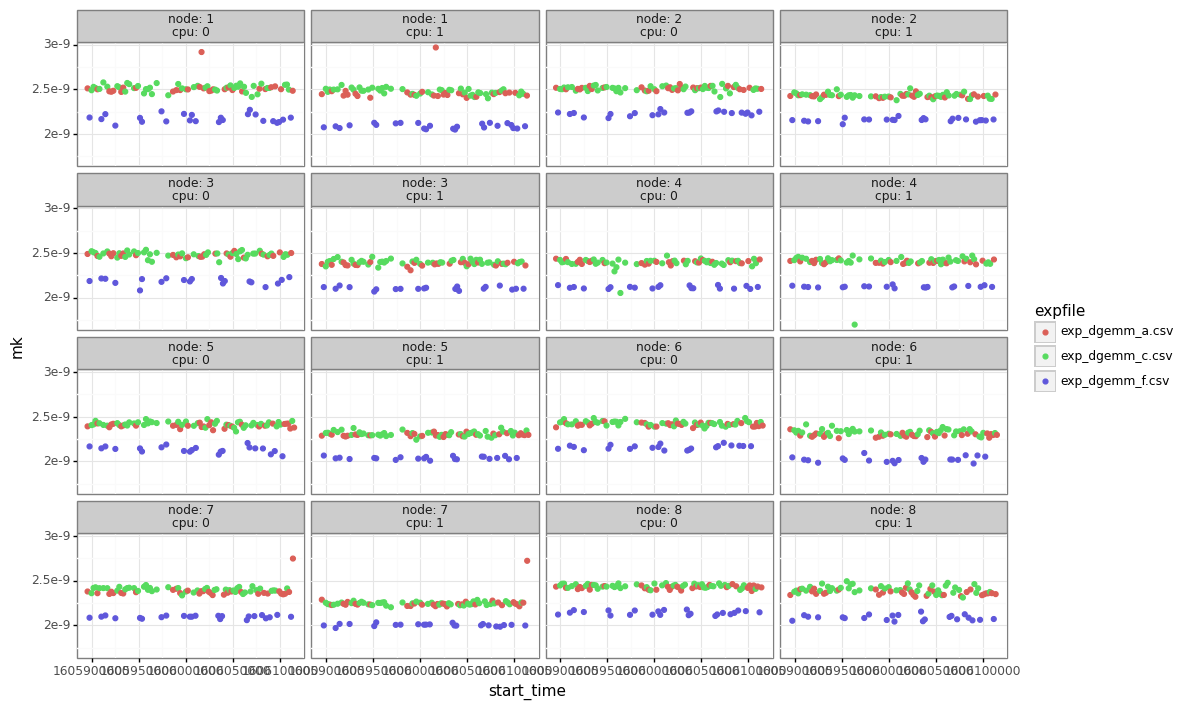

<ggplot: (-9223363302031776750)>


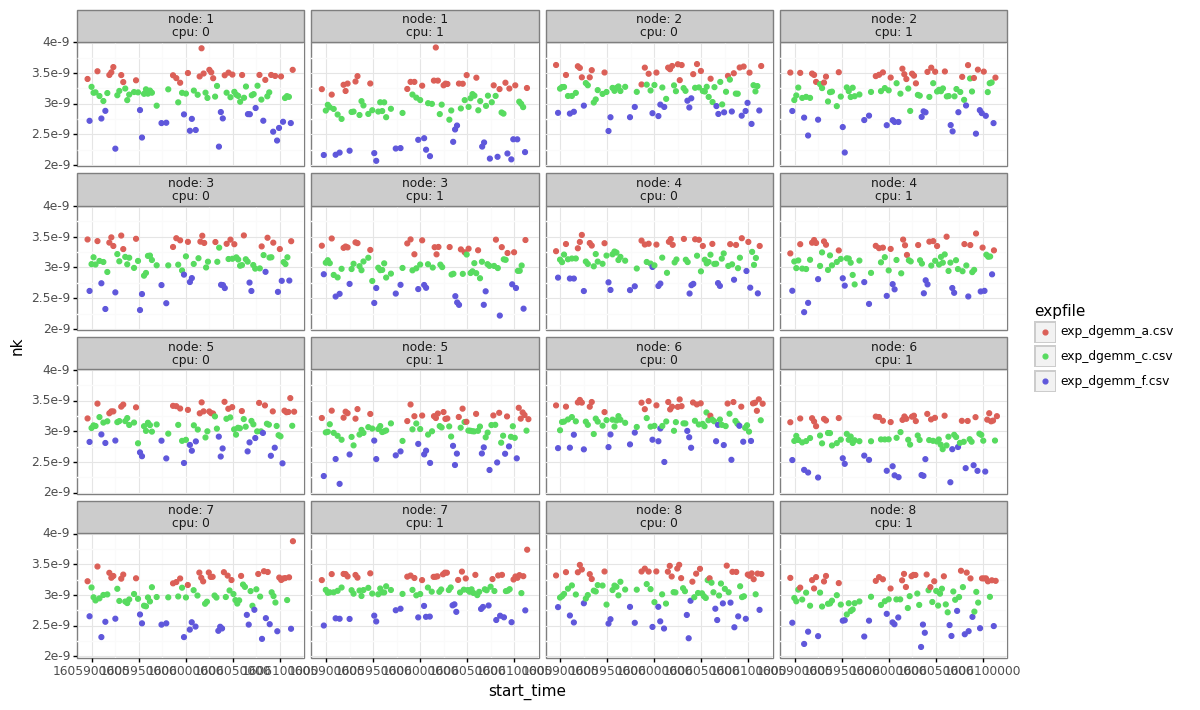

<ggplot: (-9223363302031812976)>


In [7]:
for col in ['avg_gflops', 'mnk', 'mn', 'mk', 'nk']:
    print(ggplot(aggregated_df)
        + aes(x='start_time', y=col, color='expfile')
        + geom_point()
        + theme_bw()
        + facet_wrap(['node', 'cpu'], labeller='label_both')
    )

In [8]:
first_exp = set(df.groupby('expfile')[['jobid']].min()['jobid'])
df[(df['jobid'].isin(first_exp)) & (df['node'] == df['node'].max())][['jobid', 'expfile', 'm', 'n', 'k', 'node', 'cpu', 'duration']].to_csv('/tmp/dgemm_raw_data.csv', index=False)

In [9]:
df[['expfile', 'm', 'n', 'k']].drop_duplicates().to_csv('/tmp/dgemm_expfile_content.csv', index=False)

In [10]:
aggregated_df.to_csv('/tmp/dgemm_agr_data.csv', index=False)

In [11]:
del df
del aggregated_df

## Monitoring

In [12]:
dataframes = []
for f in archives:#[:100]:  # too many archives, let's just take the first part
    tmp = ae.read_monitoring(f)
    tmp['expfile'] = ae.read_yaml(f, 'info.yaml')['expfile'][0]
    dataframes.append(tmp)
monitoring = pandas.concat(dataframes)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
monitoring['in_exp'] = (monitoring['timestamp'] > monitoring['start_exp'] + 60) & (monitoring['timestamp'] < monitoring['stop_exp'] - 60)
monitoring['hostname'] = monitoring['cluster'] + '-' + monitoring['node'].astype(str)
print(len(monitoring))
monitoring.head()

13383936


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,expfile,date,real_start_time,cpu_id,in_exp,hostname
0,0.001735,dahu,7,1961194,1606070717,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,1.000140,0,0,frequency,623.130165,1348.497612,exp_dgemm_c.csv,2020-11-22 18:45:17,1.606075e+09,7:0,False,dahu-7
1,5.006604,dahu,7,1961194,1606070717,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,2.613079,0,0,frequency,623.130165,1348.497612,exp_dgemm_c.csv,2020-11-22 18:45:17,1.606075e+09,7:0,False,dahu-7
2,10.011693,dahu,7,1961194,1606070717,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,1.000012,0,0,frequency,623.130165,1348.497612,exp_dgemm_c.csv,2020-11-22 18:45:17,1.606075e+09,7:0,False,dahu-7
3,15.016729,dahu,7,1961194,1606070717,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,1.596533,0,0,frequency,623.130165,1348.497612,exp_dgemm_c.csv,2020-11-22 18:45:17,1.606075e+09,7:0,False,dahu-7
4,20.028474,dahu,7,1961194,1606070717,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,1.597045,0,0,frequency,623.130165,1348.497612,exp_dgemm_c.csv,2020-11-22 18:45:17,1.606075e+09,7:0,False,dahu-7


In [13]:
grouped_mon = monitoring[monitoring.in_exp].groupby(['node', 'cpu', 'cpu_id', 'kind', 'expfile', 'real_start_time'])[['value']].mean().reset_index()
grouped_mon

,node,cpu,cpu_id,kind,expfile,real_start_time,value
0,1,0,1:0,frequency,exp_dgemm_a.csv,1.605899e+09,2.015852
1,1,0,1:0,frequency,exp_dgemm_a.csv,1.605910e+09,2.013443
2,1,0,1:0,frequency,exp_dgemm_a.csv,1.605923e+09,2.010327
3,1,0,1:0,frequency,exp_dgemm_a.csv,1.605925e+09,2.014165
4,1,0,1:0,frequency,exp_dgemm_a.csv,1.605927e+09,2.013178
...,...,...,...,...,...,...,...
3091,8,1,8:1,temperature,exp_dgemm_f.csv,1.606085e+09,60.601491
3092,8,1,8:1,temperature,exp_dgemm_f.csv,1.606089e+09,59.135894
3093,8,1,8:1,temperature,exp_dgemm_f.csv,1.606093e+09,58.252867
3094,8,1,8:1,temperature,exp_dgemm_f.csv,1.606101e+09,60.184633


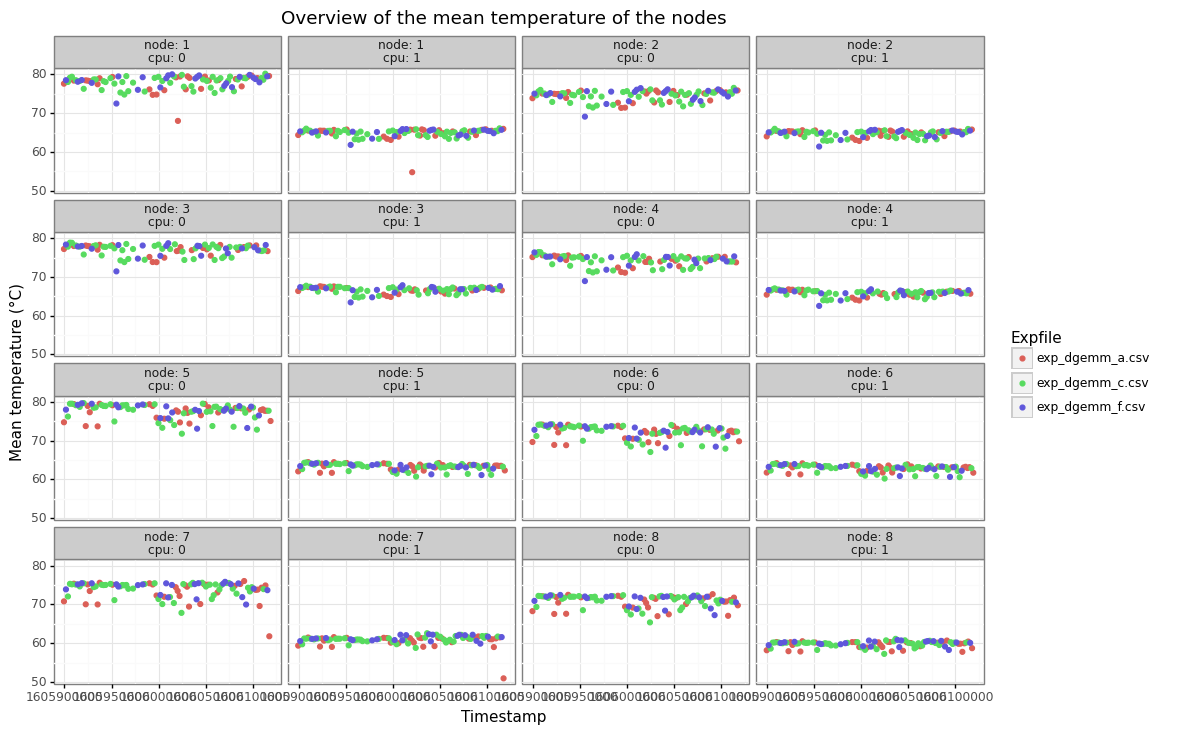

<ggplot: (8734791459413)>

In [14]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'temperature'])
    + aes(x='real_start_time', y='value', color='expfile')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'cpu'], labeller='label_both')
    + labs(x='Timestamp', y='Mean temperature (°C)', color='Expfile')
    + ggtitle('Overview of the mean temperature of the nodes')
)

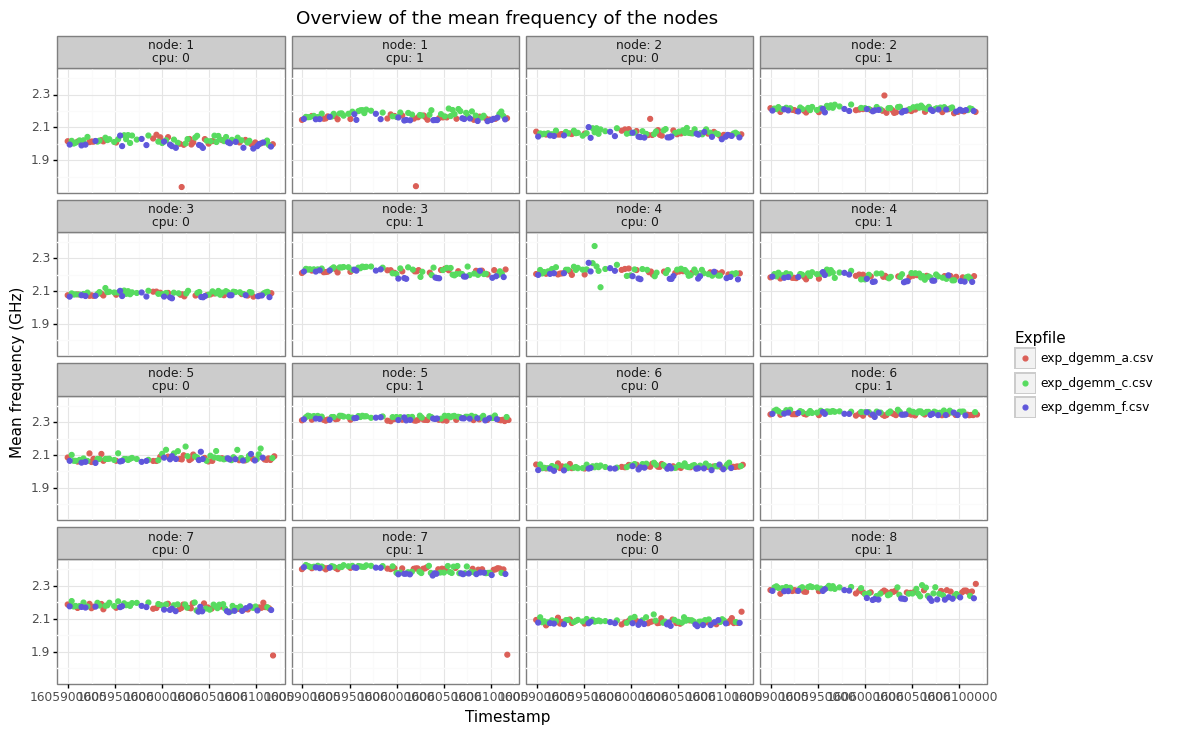

<ggplot: (8734653856404)>

In [15]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'frequency'])
    + aes(x='real_start_time', y='value', color='expfile')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'cpu'], labeller='label_both')
    + labs(x='Timestamp', y='Mean frequency (GHz)', color='Expfile')
    + ggtitle('Overview of the mean frequency of the nodes')
)

In [16]:
import re
reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
reg.fullmatch('power_package-1').groupdict()

{'cpu_id': '1', 'sub_group': None}

In [17]:
import numpy
import re

def melt_power(df, idcol):
    reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
    result = []
    columns = list(df.columns)
    for col in columns:
        match = reg.fullmatch(col)
        if match is None:
            continue
        tmp = df[idcol].copy()
        tmp['value'] = df[col]
        tmp['CPU'] = int(match.groupdict()['cpu_id'])
        tmp['subgroup'] = str(match.groupdict()['sub_group'])
        result.append(tmp)
    return pandas.concat(result)

def read_monitoring_power(archive_name, columns=None):
    '''
    Read the durations of a BLAS calibration in an archive.
    '''
    csv_name = 'monitoring.csv'
    df = ae.read_archive_csv_enhanced(archive_name, csv_name, columns=columns)
    df['timestamp'] = pandas.to_datetime(df['timestamp'])
    columns = ['timestamp', 'cluster', 'node', 'jobid', 'start_time', 'expfile_hash']
    power = melt_power(df, columns)
    power['timestamp'] = power['timestamp'].astype(numpy.int64) / 10 ** 9
    power['timestamp'] = power['timestamp'] - power['timestamp'].min()
    return power

dataframes = []
for f in archives:
    tmp = read_monitoring_power(f)
    tmp['expfile'] = ae.read_yaml(f, 'info.yaml')['expfile'][0]
    dataframes.append(tmp)
power = pandas.concat(dataframes)

for jobid in power['jobid'].unique():
    for col in ['start_exp', 'stop_exp']:
        val = monitoring[monitoring['jobid'] == jobid][col].unique()
        assert len(val) == 1
        power.loc[power['jobid'] == jobid, col] = val[0]
power.head()

,timestamp,cluster,node,jobid,start_time,expfile_hash,value,CPU,subgroup,expfile,start_exp,stop_exp
0,0.001735,dahu,7,1961194,1606070717,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,44.854634,1,None,exp_dgemm_c.csv,623.130165,1348.497612
1,5.006604,dahu,7,1961194,1606070717,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,104.479861,1,None,exp_dgemm_c.csv,623.130165,1348.497612
2,10.011693,dahu,7,1961194,1606070717,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,87.324893,1,None,exp_dgemm_c.csv,623.130165,1348.497612
3,15.016729,dahu,7,1961194,1606070717,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,40.083393,1,None,exp_dgemm_c.csv,623.130165,1348.497612
4,20.028474,dahu,7,1961194,1606070717,66dcbf9445c381951bce9c0e7e82fae1e07c997848da4a...,43.518597,1,None,exp_dgemm_c.csv,623.130165,1348.497612


In [18]:
grouped_power = power[(power['timestamp'] > power['start_exp']+60) & (power['timestamp'] < power['stop_exp']-60)].groupby(['subgroup', 'node', 'CPU', 'expfile', 'start_time'])[['value']].mean().reset_index()
grouped_power

,subgroup,node,CPU,expfile,start_time,value
0,None,1,0,exp_dgemm_a.csv,1605895434,124.638607
1,None,1,0,exp_dgemm_a.csv,1605905961,124.638872
2,None,1,0,exp_dgemm_a.csv,1605918583,124.638833
3,None,1,0,exp_dgemm_a.csv,1605920713,124.638711
4,None,1,0,exp_dgemm_a.csv,1605922839,124.638838
...,...,...,...,...,...,...
3091,dram,8,1,exp_dgemm_f.csv,1606080907,11.409339
3092,dram,8,1,exp_dgemm_f.csv,1606085012,11.436604
3093,dram,8,1,exp_dgemm_f.csv,1606089096,11.429194
3094,dram,8,1,exp_dgemm_f.csv,1606097175,11.420052


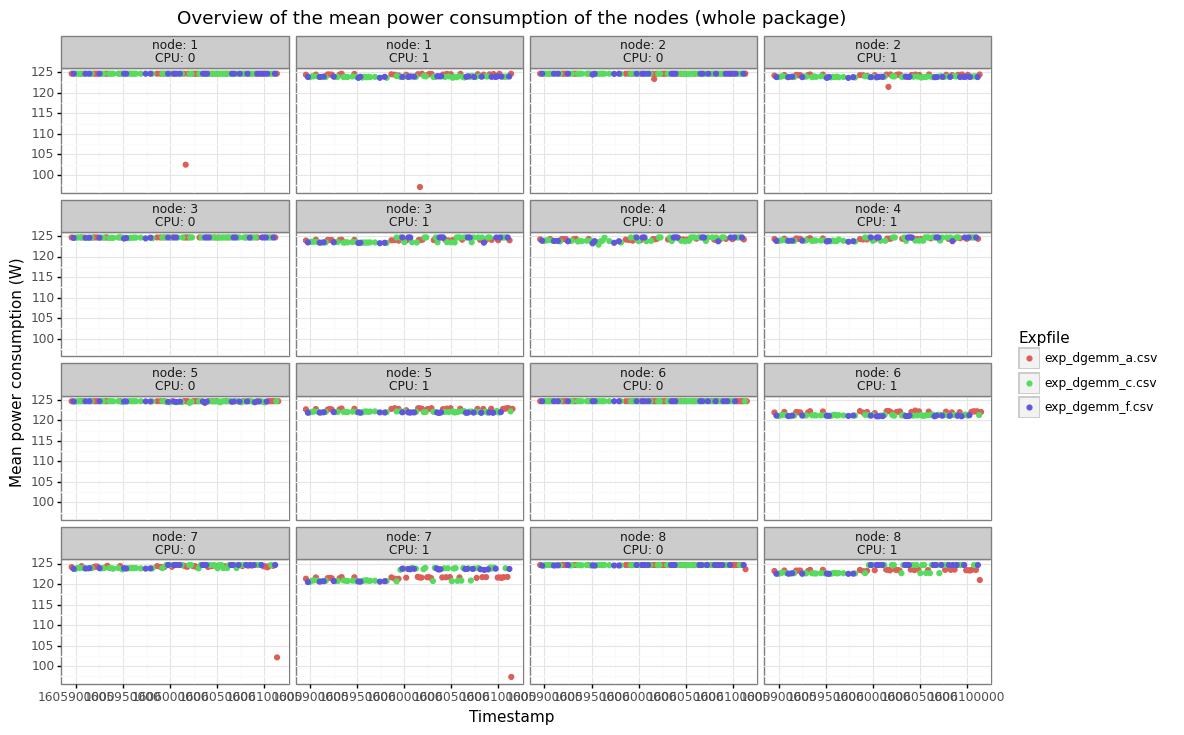

<ggplot: (-9223363302201382470)>

In [19]:
(ggplot(grouped_power[grouped_power['subgroup'] == 'None'])
    + aes(x='start_time', y='value', color='expfile')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'CPU'], labeller='label_both')
    + labs(x='Timestamp', y='Mean power consumption (W)', color='Expfile')
    + ggtitle('Overview of the mean power consumption of the nodes (whole package)')
)

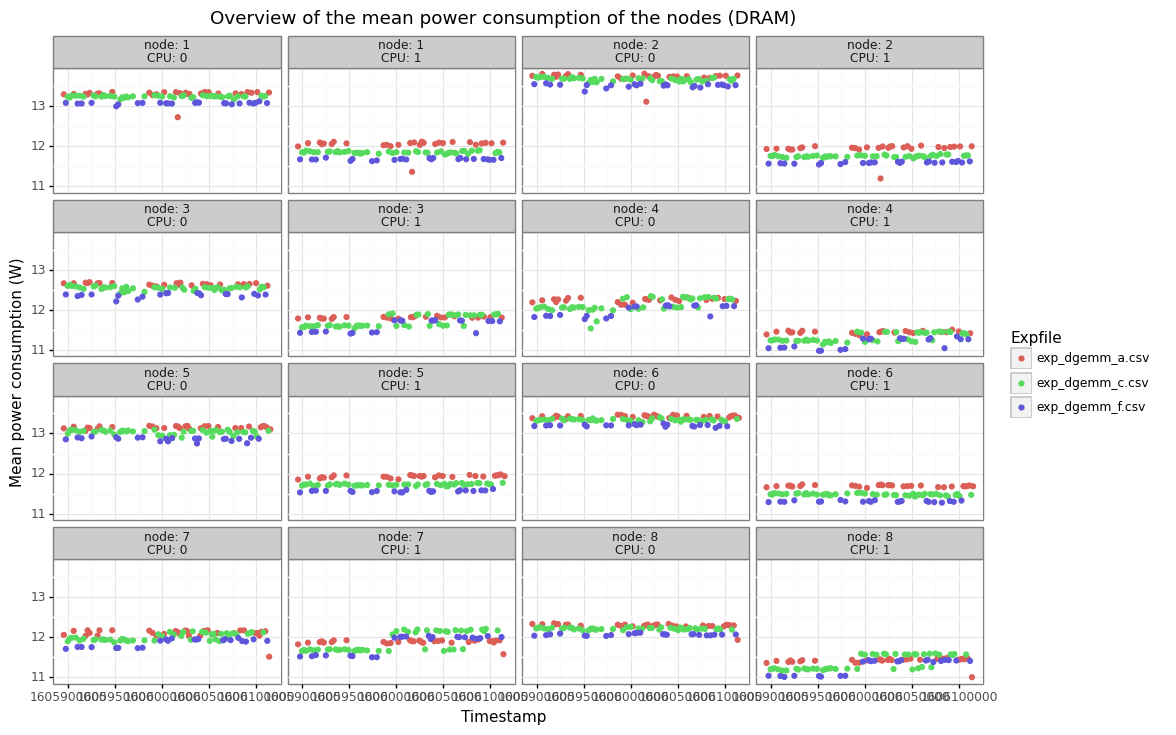

<ggplot: (8734653572486)>

In [20]:
(ggplot(grouped_power[grouped_power['subgroup'] == 'dram'])
    + aes(x='start_time', y='value', color='expfile')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'CPU'], labeller='label_both')
    + labs(x='Timestamp', y='Mean power consumption (W)', color='Expfile')
    + ggtitle('Overview of the mean power consumption of the nodes (DRAM)')
)

In [21]:
tmp_mon = grouped_mon.rename(columns={'real_start_time': 'start_time'})
tmp_pow = grouped_power.rename(columns={'CPU': 'cpu'})
tmp_pow['kind'] = 'power'
tmp_pow.loc[tmp_pow['subgroup'] == 'None', 'subgroup'] = 'package'
dump = pandas.concat([tmp_mon, tmp_pow])[['node', 'cpu', 'kind', 'expfile', 'start_time', 'value', 'subgroup']]
dump.to_csv('/tmp/dgemm_agr_monitoring.csv', index=False)
dump

,node,cpu,kind,expfile,start_time,value,subgroup
0,1,0,frequency,exp_dgemm_a.csv,1.605899e+09,2.015852,NaN
1,1,0,frequency,exp_dgemm_a.csv,1.605910e+09,2.013443,NaN
2,1,0,frequency,exp_dgemm_a.csv,1.605923e+09,2.010327,NaN
3,1,0,frequency,exp_dgemm_a.csv,1.605925e+09,2.014165,NaN
4,1,0,frequency,exp_dgemm_a.csv,1.605927e+09,2.013178,NaN
...,...,...,...,...,...,...,...
3091,8,1,power,exp_dgemm_f.csv,1.606081e+09,11.409339,dram
3092,8,1,power,exp_dgemm_f.csv,1.606085e+09,11.436604,dram
3093,8,1,power,exp_dgemm_f.csv,1.606089e+09,11.429194,dram
3094,8,1,power,exp_dgemm_f.csv,1.606097e+09,11.420052,dram
